In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


In [ ]:
# Load Image
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_image = np.expand_dims(img_array, axis=0)
input_image = preprocess_input(input_image)


In [ ]:
# 3. Load Pretrained ResNet50 Model
model = ResNet50(weights='imagenet')

original_preds = model.predict(input_image)
print("Original prediction:", decode_predictions(original_preds, top=3)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Original prediction: [('n02091244', 'Ibizan_hound', np.float32(0.16036324)), ('n02091831', 'Saluki', np.float32(0.113766305)), ('n02099712', 'Labrador_retriever', np.float32(0.09416799))]


In [ ]:
# 4. FGSM Attack
loss_object = tf.keras.losses.CategoricalCrossentropy()
epsilon = 0.05

label_index = tf.argmax(original_preds[0])
label = tf.one_hot(label_index, 1000)
label = tf.reshape(label, (1, 1000))

@tf.function
def create_adversarial_image(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    return tf.clip_by_value(adversarial_image, -128.0, 128.0)


In [ ]:
# 5. Generate Adversarial Image
adv_image = create_adversarial_image(input_image, label)
adv_preds = model.predict(adv_image)
print("Adversarial prediction:", decode_predictions(adv_preds, top=3)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Adversarial prediction: [('n02099712', 'Labrador_retriever', np.float32(0.11991609)), ('n02091244', 'Ibizan_hound', np.float32(0.093574665)), ('n02091831', 'Saluki', np.float32(0.08809871))]


In [ ]:
# 6. Add Gaussian Noise
gaussian_noise = np.random.normal(loc=0.0, scale=epsilon, size=input_image.shape)
noisy_image = tf.clip_by_value(input_image + gaussian_noise, -128.0, 128.0)
gauss_preds = model.predict(noisy_image)
print("Gaussian noise prediction:", decode_predictions(gauss_preds, top=3)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Gaussian noise prediction: [('n02091244', 'Ibizan_hound', np.float32(0.14784728)), ('n02091831', 'Saluki', np.float32(0.12623852)), ('n02099712', 'Labrador_retriever', np.float32(0.09812007))]


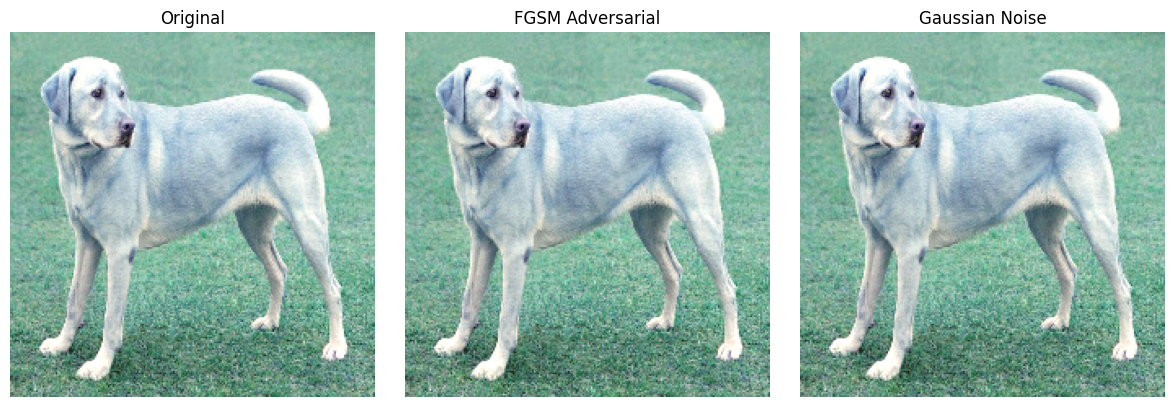

In [ ]:
# 7. Visualize All 3 Images
def deprocess(img_tensor):
    img = img_tensor[0].numpy()
    img = np.clip(((img + 128) / 255.0), 0, 1)
    return img

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(deprocess(tf.convert_to_tensor(input_image)))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(deprocess(adv_image))
plt.title("FGSM Adversarial")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(deprocess(tf.convert_to_tensor(noisy_image)))
plt.title("Gaussian Noise")
plt.axis('off')

plt.tight_layout()
plt.show()
